In [1]:
# """
# In this notebook , how can we use milvus vector database to store and retrieve
# For embedding we will use openai embedding model
# """

In [2]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [3]:
import os

os.chdir("../..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures


In [4]:
from src.utils import get_llm, get_embedder

In [5]:
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
embedder = get_embedder()
print(len(embedder.embed_query("hello world")))

1536


In [ ]:
from pymilvus import Collection, MilvusException, connections, db, utility
from langchain_milvus import BM25BuiltInFunction, Milvus
from uuid import uuid4
from langchain_core.documents import Document

##### Experiment with Milvus #####

In [8]:
conn = connections.connect(host="127.0.0.1", port=19530)

In [8]:
# Check if the database exists, if yes: use it, else: create and use it
db_name = "milvus_demo"
try:
    existing_databases = db.list_database()
    if db_name in existing_databases:
        print(f"Database '{db_name}' already exists.")
    else:
        print(f"Database '{db_name}' does not exist. Creating...")
        db.create_database(db_name)
        print(f"Database '{db_name}' created successfully.")

    db.using_database(db_name)
    print(f"Using database '{db_name}'.")
except MilvusException as e:
    print(f"An error occurred: {e}")

Database 'milvus_demo' already exists.
Using database 'milvus_demo'.


<!-- #### STEPS THAT WE WILL FOLLOW:
1. Create a basic vector store which will only store the documents and their embeddings and metadata.
2. Create a retriever that will retrieve the documents based on the query.
3. Then we will deep dive into hybrid search and how to use it with the vector store using BM25.
4. Finally, we will create a retriever that will use the hybrid search to retrieve the documents based on the query. -->

In [9]:
URI = "http://localhost:19530"
vectordb_config = {"uri": URI, "token": "root:Milvus", "db_name": "milvus_demo"}

In [10]:
basic_vectordb = Milvus(
    embedding_function = embedder,
    connection_args = vectordb_config,
    index_params={"index_type": "FLAT", "metric_type": "L2"},
    consistency_level="Strong",
    drop_old=True,
    collection_name="langchain_milvus",
)


In [11]:
# basic_vectordb.collection_name

In [12]:
document_1 = Document(
    page_content="I had chocolate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)


In [13]:
documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))]

basic_vectordb.add_documents(documents=documents, ids=uuids)

['967f6ca1-6939-48e8-af31-b4d26575daad',
 '40686dba-5cfb-4be3-9357-2eac08235b24',
 'ee3fd924-e6b7-4118-aaef-533c5247e541',
 '5d300317-d25b-469e-8967-35e8b6bb3aac',
 '0b085861-2089-404a-8bf0-db035d87828e',
 '3690ebca-a913-4c17-bf9f-e6467642875e',
 'dddde641-4cf7-45f2-ac9b-ff6de8c0ef84',
 '25cdedd3-1cfd-47fc-b510-8dd3daef73d1',
 '80fd9aa3-c7c9-4d85-8630-d68f0dd15b17',
 'eaacf118-0f3e-4ccb-8d32-71ae6ae451cf']

In [14]:
# retrieving documents
results = basic_vectordb.similarity_search(
    "LangChain provides abstractions to make working with LLMs easy",
    k=2,
    expr='source == "tweet"',
)
for res in results:
    print(f"* {res.page_content} && {res.metadata}")


* Building an exciting new project with LangChain - come check it out! && {'source': 'tweet', 'pk': 'ee3fd924-e6b7-4118-aaef-533c5247e541'}
* LangGraph is the best framework for building stateful, agentic applications! && {'source': 'tweet', 'pk': '25cdedd3-1cfd-47fc-b510-8dd3daef73d1'}


In [15]:
# # lcel retriever
# retriever = basic_vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 1})
# retriever.invoke("Stealing from the bank is a crime", filter={"source": "news"})

#### Hybrid search 
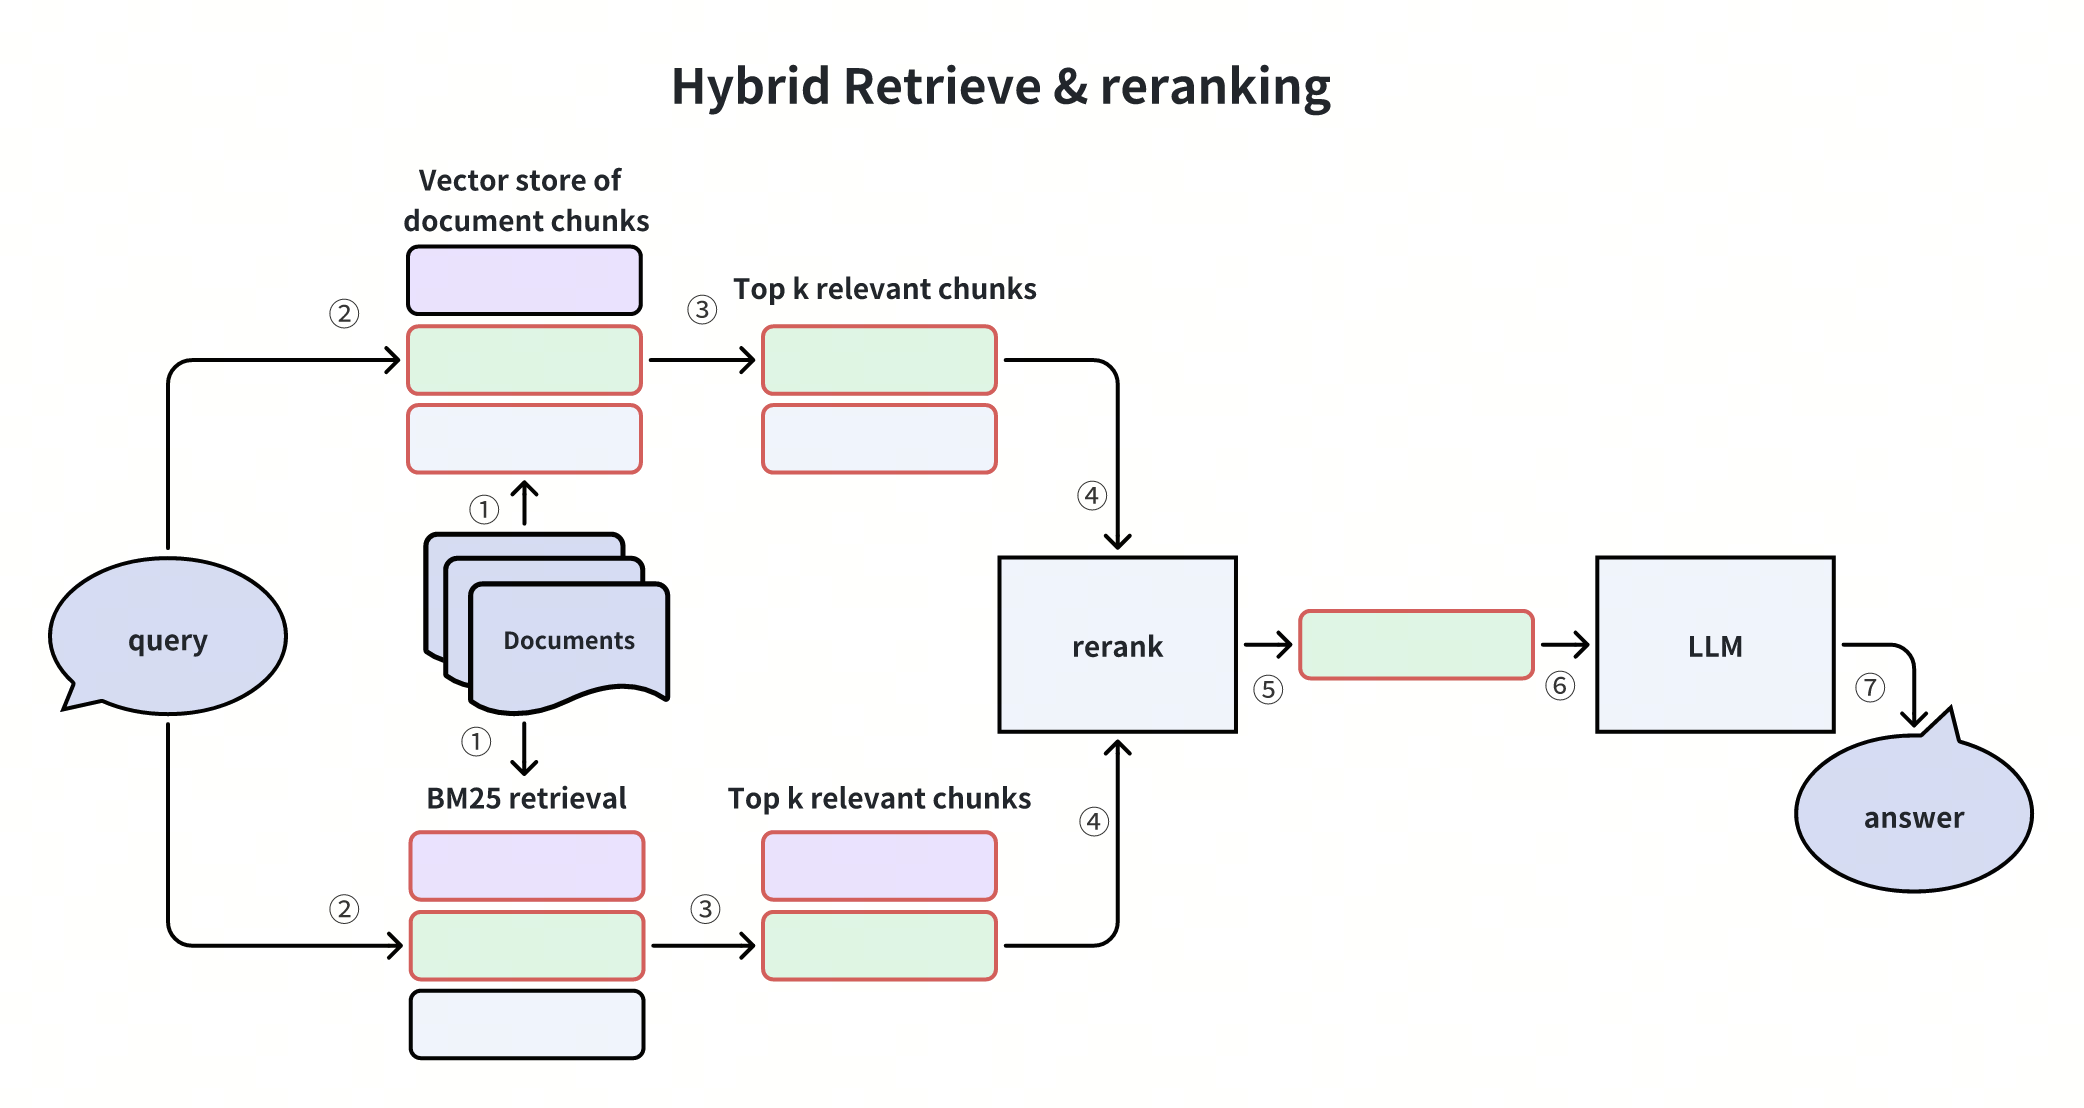

In [16]:
# Create a new database
docs = [
    Document(
        page_content="In 'The Whispering Walls' by Ava Moreno, a young journalist named Sophia uncovers a decades-old conspiracy hidden within the crumbling walls of an ancient mansion, where the whispers of the past threaten to destroy her own sanity.",
        metadata={"category": "Mystery"},
    ),
    Document(
        page_content="In 'The Last Refuge' by Ethan Blackwood, a group of survivors must band together to escape a post-apocalyptic wasteland, where the last remnants of humanity cling to life in a desperate bid for survival.",
        metadata={"category": "Post-Apocalyptic"},
    ),
    Document(
        page_content="In 'The Memory Thief' by Lila Rose, a charismatic thief with the ability to steal and manipulate memories is hired by a mysterious client to pull off a daring heist, but soon finds themselves trapped in a web of deceit and betrayal.",
        metadata={"category": "Heist/Thriller"},
    ),
    Document(
        page_content="In 'The City of Echoes' by Julian Saint Clair, a brilliant detective must navigate a labyrinthine metropolis where time is currency, and the rich can live forever, but at a terrible cost to the poor.",
        metadata={"category": "Science Fiction"},
    ),
    Document(
        page_content="In 'The Starlight Serenade' by Ruby Flynn, a shy astronomer discovers a mysterious melody emanating from a distant star, which leads her on a journey to uncover the secrets of the universe and her own heart.",
        metadata={"category": "Science Fiction/Romance"},
    ),
    Document(
        page_content="In 'The Shadow Weaver' by Piper Redding, a young orphan discovers she has the ability to weave powerful illusions, but soon finds herself at the center of a deadly game of cat and mouse between rival factions vying for control of the mystical arts.",
        metadata={"category": "Fantasy"},
    ),
    Document(
        page_content="In 'The Lost Expedition' by Caspian Grey, a team of explorers ventures into the heart of the Amazon rainforest in search of a lost city, but soon finds themselves hunted by a ruthless treasure hunter and the treacherous jungle itself.",
        metadata={"category": "Adventure"},
    ),
    Document(
        page_content="In 'The Clockwork Kingdom' by Augusta Wynter, a brilliant inventor discovers a hidden world of clockwork machines and ancient magic, where a rebellion is brewing against the tyrannical ruler of the land.",
        metadata={"category": "Steampunk/Fantasy"},
    ),
    Document(
        page_content="In 'The Phantom Pilgrim' by Rowan Welles, a charismatic smuggler is hired by a mysterious organization to transport a valuable artifact across a war-torn continent, but soon finds themselves pursued by deadly assassins and rival factions.",
        metadata={"category": "Adventure/Thriller"},
    ),
    Document(
        page_content="In 'The Dreamwalker's Journey' by Lyra Snow, a young dreamwalker discovers she has the ability to enter people's dreams, but soon finds herself trapped in a surreal world of nightmares and illusions, where the boundaries between reality and fantasy blur.",
        metadata={"category": "Fantasy"},
    ),
]

# Create a new collection
collection_name = "book_recommendations"

uuids = [str(uuid4()) for _ in range(len(docs))]


In [17]:
# Option 1(Recommended): dense embedding + Milvus BM25 built-in function
# Use dense embedding + Milvus BM25 built-in function to assemble the hybrid retrieval vector store instance.

In [18]:
dense_index_param = {
    "metric_type": "COSINE",
    "index_type": "HNSW",
}
sparse_index_param = {
    "metric_type": "BM25",
    "index_type": "AUTOINDEX",
}

In [19]:
hybrid_vectordb = Milvus(
    embedding_function = embedder,
    connection_args = vectordb_config,
    consistency_level="Strong",
    drop_old=True,
    collection_name=collection_name,
    builtin_function=BM25BuiltInFunction(),  # output_field_names="sparse",
    vector_field=["dense", "sparse"],
    index_params = [dense_index_param, sparse_index_param],

)


In [20]:
hybrid_vectordb.add_documents(
    documents = docs,
    ids = uuids,
)

['c887ef7b-18f7-406c-89fb-bf3f4f7efa2b',
 '5401f217-a2fa-4a7e-8c4e-de6a8a73e064',
 'dea7cd0b-3a5e-4695-9bda-467143e02635',
 '58b71695-e42f-43d7-92cd-6b5adad2c005',
 'f6d1b9c9-7058-458d-9949-5b5b06ec6b06',
 '81027ff7-e1e5-447c-a7b5-6adcfd940eb3',
 '34995d98-0bad-4d54-895b-e03b6ad7a1b7',
 '1b3e95d5-d9fd-4ca3-bb75-6c9bbc6de9c4',
 '37a0e4ba-64a3-4b90-bb51-50fe9e7a16ac',
 '8e9c4f7c-745f-4a7a-9996-457408219925']

In [21]:
query = "What are the thriler novels Lila has written and what are their contents?"

hybrid_vectordb.similarity_search(
    query, k=2, ranker_type="weighted", ranker_params={"weights": [0.6, 0.4]}
)

[Document(metadata={'category': 'Heist/Thriller', 'pk': 'dea7cd0b-3a5e-4695-9bda-467143e02635'}, page_content="In 'The Memory Thief' by Lila Rose, a charismatic thief with the ability to steal and manipulate memories is hired by a mysterious client to pull off a daring heist, but soon finds themselves trapped in a web of deceit and betrayal."),
 Document(metadata={'category': 'Fantasy', 'pk': '8e9c4f7c-745f-4a7a-9996-457408219925'}, page_content="In 'The Dreamwalker's Journey' by Lyra Snow, a young dreamwalker discovers she has the ability to enter people's dreams, but soon finds herself trapped in a surreal world of nightmares and illusions, where the boundaries between reality and fantasy blur.")]

In [22]:
hybrid_vectordb.similarity_search_with_score(
    query,
    k=2,
    ranker_type="weighted",
    ranker_params={"weights": [0.5, 0.5]},
)

[(Document(metadata={'category': 'Heist/Thriller', 'pk': 'dea7cd0b-3a5e-4695-9bda-467143e02635'}, page_content="In 'The Memory Thief' by Lila Rose, a charismatic thief with the ability to steal and manipulate memories is hired by a mysterious client to pull off a daring heist, but soon finds themselves trapped in a web of deceit and betrayal."),
  0.713068962097168),
 (Document(metadata={'category': 'Fantasy', 'pk': '8e9c4f7c-745f-4a7a-9996-457408219925'}, page_content="In 'The Dreamwalker's Journey' by Lyra Snow, a young dreamwalker discovers she has the ability to enter people's dreams, but soon finds herself trapped in a surreal world of nightmares and illusions, where the boundaries between reality and fantasy blur."),
  0.659309983253479)]

In [23]:
hybrid_vectordb.similarity_search(query, k=2, ranker_type="rrf", ranker_params={"k": 100})

[Document(metadata={'category': 'Heist/Thriller', 'pk': 'dea7cd0b-3a5e-4695-9bda-467143e02635'}, page_content="In 'The Memory Thief' by Lila Rose, a charismatic thief with the ability to steal and manipulate memories is hired by a mysterious client to pull off a daring heist, but soon finds themselves trapped in a web of deceit and betrayal."),
 Document(metadata={'category': 'Fantasy', 'pk': '81027ff7-e1e5-447c-a7b5-6adcfd940eb3'}, page_content="In 'The Shadow Weaver' by Piper Redding, a young orphan discovers she has the ability to weave powerful illusions, but soon finds herself at the center of a deadly game of cat and mouse between rival factions vying for control of the mystical arts.")]

#### Small Rag example using milvus

In [9]:
# docker-compose up -d --build

In [10]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    web_paths=(
        "https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)

docs = text_splitter.split_documents(documents)
print(f"Total {len(docs)} documents loaded")


USER_AGENT environment variable not set, consider setting it to identify your requests.


Total 54 documents loaded


In [11]:
conn = connections.connect(host="127.0.0.1", port=19530)
# Check if the database exists, if yes: use it, else: create and use it
db_name = "milvus_demo"
try:
    existing_databases = db.list_database()
    if db_name in existing_databases:
        print(f"Database '{db_name}' already exists.")
    else:
        print(f"Database '{db_name}' does not exist. Creating...")
        db.create_database(db_name)
        print(f"Database '{db_name}' created successfully.")

    db.using_database(db_name)
    print(f"Using database '{db_name}'.")
except MilvusException as e:
    print(f"An error occurred: {e}")

Database 'milvus_demo' already exists.
Using database 'milvus_demo'.


In [12]:
URI = "http://localhost:19530"
vectordb_config = {"uri": URI, "token": "root:Milvus", "db_name": "milvus_demo"}

In [13]:
dense_index_param = {
    "metric_type": "COSINE",
    "index_type": "HNSW",
}
sparse_index_param = {
    "metric_type": "BM25",
    "index_type": "AUTOINDEX",
}

In [16]:
vector_db = Milvus.from_documents(
    documents = docs,
    embedding = embedder,
    connection_args = vectordb_config,
    collection_name = "lilian_weng_blog",
    drop_old = True,
    builtin_function=BM25BuiltInFunction(),
    vector_field=["dense", "sparse"],
    index_params = [dense_index_param, sparse_index_param],
)

In [18]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Initialize the OpenAI language model for response generation
llm = get_llm()

# Define the prompt template for generating AI responses
PROMPT_TEMPLATE = """
Human: You are an AI assistant, and provides answers to questions by using fact based and statistical information when possible.
Use the following pieces of information to provide a concise answer to the question enclosed in <question> tags.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{context}
</context>

<question>
{question}
</question>

The response should be specific and use statistics or numbers when possible.

Assistant:"""

# Create a PromptTemplate instance with the defined template and input variables
prompt = PromptTemplate(
    template=PROMPT_TEMPLATE, input_variables=["context", "question"]
)

In [19]:

# Convert the vector store to a retriever
retriever = vector_db.as_retriever()


# Define a function to format the retrieved documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [20]:
# Define the RAG (Retrieval-Augmented Generation) chain for AI response generation
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


In [21]:
query = "What is PAL and PoT?"
res = rag_chain.invoke(query)
res

'PAL (Program-aided Language models) and PoT (Program of Thoughts prompting) are techniques designed to enhance the reasoning and computational capabilities of large language models (LLMs).\n\n1. **PAL (Program-aided Language models)**:\n   - PAL involves generating programming language statements to resolve natural language reasoning problems.\n   - This approach offloads the solution step to a runtime, such as a Python interpreter, which handles the actual computation.\n   - By doing so, PAL decouples complex computation and reasoning, allowing the language model to focus on generating accurate code that can be executed to obtain the final answer.\n   - This method relies on the language model having good coding skills to generate correct and efficient code.\n\n2. **PoT (Program of Thoughts prompting)**:\n   - PoT extends the idea of Chain-of-Thought (CoT) prompting by disentangling computation from reasoning.\n   - It involves the language model generating a sequence of thought step

########################## END ##########################